In [63]:
import os
import pandas as pd
import numpy as np

sdf_dir = '../Data/other/SDF poses'
sdf_names = {f.replace('.sdf', '') for f in os.listdir(sdf_dir) if f.endswith('.sdf')}

# make empty dataframe
df = pd.DataFrame(columns=['cluster', 'name', 'true_label', 'prediction'])
data = pd.read_csv('../Data/docs/7.compounds_for_validaton.csv')
names = pd.DataFrame(data['name'], columns=['name'])
df = pd.concat([df, names], ignore_index=True)
df['cluster'] = 'cluster_1'
df['prediction'] = 0
df['true_label'] = df['name'].apply(lambda x: 1 if x in sdf_names else 0)

clusters = [f'cluster_{i+1}' for i in range(7)]
df = pd.concat([
    df.assign(cluster=cluster) for cluster in clusters
], ignore_index=True)
df

,cluster,name,true_label,prediction
0,cluster_1,B4B_5OXG,1,0
1,cluster_1,C9U_6JUX,1,0
2,cluster_1,H8H_6ZGC,1,0
3,cluster_1,XQX_8UWR,1,0
4,cluster_1,LDN_3Q4U,1,0
...,...,...,...,...
492,cluster_7,LARR_PDGFRB,0,0
493,cluster_7,WVSC_CDC7,0,0
494,cluster_7,KMZA_CTSH,0,0
495,cluster_7,FQDY_PIK3CB,0,0


In [64]:
#merge
version = "Scaffold" # PLIP or Scaffold

df2 = pd.read_csv(f'../Results/pharmacophores/{version}_based/{version}_results/merged_output.csv')
df2 = df2.rename(columns={'filename':'name'})
df['prediction'] = df.apply(
    lambda row: 1 if ((df2['cluster'] == row['cluster']) & (df2['name'] == row['name'])).any() else 0,
    axis=1
)

In [65]:
print(df.groupby('cluster')[['true_label', 'prediction']].sum())

           true_label  prediction
cluster                          
cluster_1          31           6
cluster_2          31           3
cluster_3          31           3
cluster_4          31           2
cluster_5          31          13
cluster_6          31           6
cluster_7          31           3


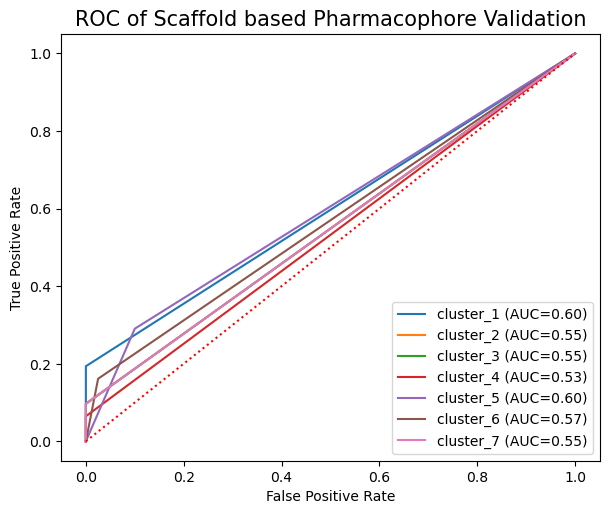

In [66]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))

for cluster, group in df.groupby('cluster'):
    true_labels = group['true_label'].astype(int)
    predicted_fit = group['prediction'].astype(int)
    size = true_labels.sum()
    
    if true_labels.nunique() < 2 or predicted_fit.nunique() < 2:
        continue

    fpr, tpr, _ = roc_curve(true_labels, predicted_fit)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{cluster} (AUC={roc_auc:.2f})")


plt.plot([0, 1], [0, 1], linestyle='dotted', color='red')
plt.xlabel("False Positive Rate", fontsize=10)
plt.tight_layout()
plt.ylabel("True Positive Rate", fontsize=10)
plt.title(f"ROC of {version} based Pharmacophore Validation", fontsize=15)
plt.legend(loc='lower right', fontsize=10)
plt.grid(False)
plt.savefig(f"../Results/images/ROC {version}.png", dpi=300)
plt.show()

<Figure size 400x400 with 0 Axes>

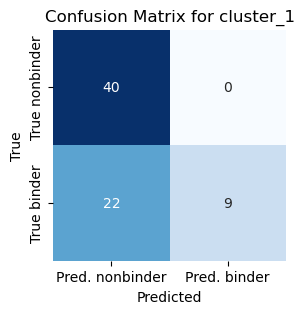

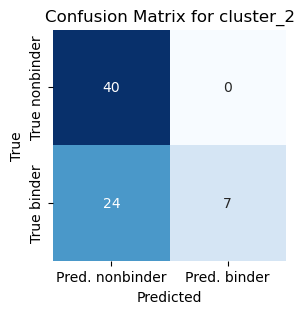

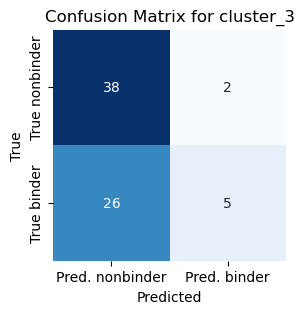

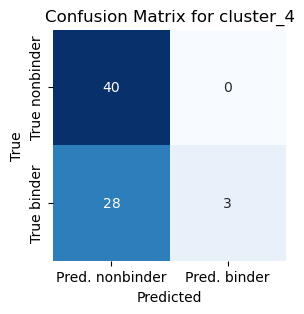

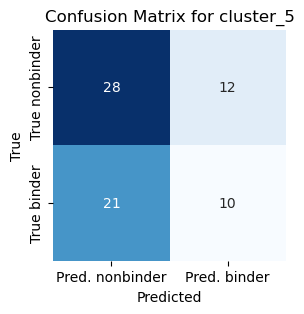

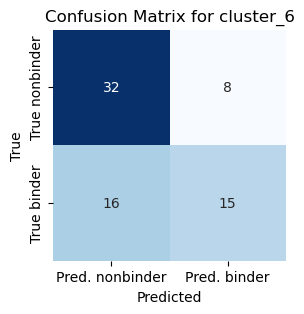

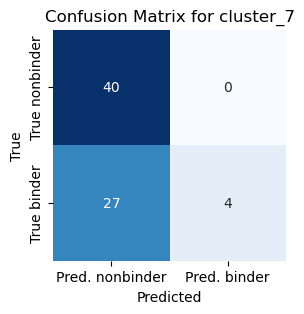

In [9]:
# plot confusion matrix for each cluster
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(4, 4))
for cluster, group in df.groupby('cluster'):
    true_labels = group['true_label'].astype(int)
    predicted_fit = group['prediction'].astype(int)
    
    if true_labels.nunique() < 2 or predicted_fit.nunique() < 2:
        continue

    cm = confusion_matrix(true_labels, predicted_fit)
    
    plt.figure(figsize=(3, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Pred. nonbinder', 'Pred. binder'],
                yticklabels=['True nonbinder', 'True binder'])
    
    plt.title(f'Confusion Matrix for {cluster}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [12]:
from rdkit import Chem
import pandas as pd

sdf_path = '../Results/Screening results/Enamine_output.sdf'
supplier = Chem.SDMolSupplier(sdf_path)

data = []

for mol in supplier:
    if mol is None:
        continue
    name = mol.GetProp('_Name').split()[0] if mol.HasProp('_Name') else None
    affinity = mol.GetProp('minimizedAffinity') if mol.HasProp('minimizedAffinity') else None
    rmsd = mol.GetProp('minimizedRMSD') if mol.HasProp('minimizedRMSD') else None
    smiles = Chem.MolToSmiles(mol)

    data.append({
        'filename': name,
        'affinity': affinity,
        'rmsd': rmsd,
        'smiles': smiles
    })

df = pd.DataFrame(data)
df.to_csv('../Results/Screening results/Enamine_results.csv', index=False)


[18:15:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:15:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:15:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:15:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:15:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:15:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:15:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:15:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[18:15:08] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

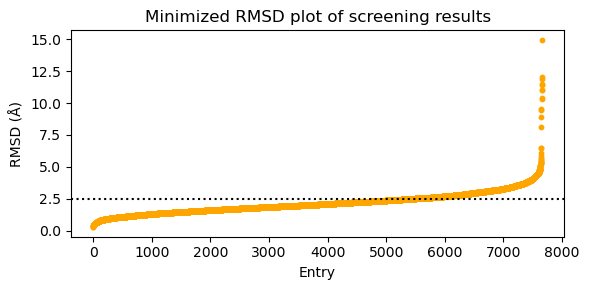

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Load your output
df = pd.read_csv('../Results/Screening results/Enamine_results.csv')

# Convert RMSD to numeric (handle any missing or bad values)
rmsd_values = pd.to_numeric(df['rmsd'], errors='coerce').dropna().sort_values().values

# Plot
plt.figure(figsize=(6, 3))
plt.scatter(range(len(rmsd_values)), rmsd_values, color='orange', s=10)
plt.axhline(y=2.5, color='black', linestyle='dotted')  # cutoff line

plt.ylabel("RMSD (Å)", fontsize=10)
plt.xlabel("Entry", fontsize=10)
plt.title("Minimized RMSD plot of screening results")
plt.tight_layout()
plt.show()


In [27]:
import numpy as np

# Normalize to 0-1
rmsd_norm = (df['rmsd'] - df['rmsd'].min()) / (df['rmsd'].max() - df['rmsd'].min())
score_norm = (df['affinity'] - df['affinity'].min()) / (df['affinity'].max() - df['affinity'].min())

# Combine (equal weights)
combined_score = rmsd_norm + score_norm

df['combined_score'] = combined_score

# Sort by combined_score ascending (lower is better)
best_df = df.sort_values('combined_score')


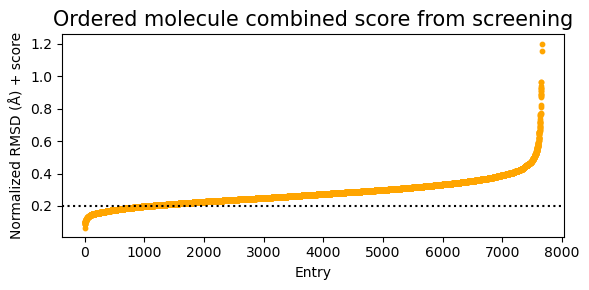

In [35]:
plt.figure(figsize=(6, 3))
plt.scatter(range(len(best_df)), best_df['combined_score'], color='orange', s=10, label='Combined Score')

plt.axhline(color='black', linestyle='dotted', y=.2)
plt.ylabel("Normalized RMSD (Å) + score")
plt.xlabel("Entry")
plt.title("Ordered molecule combined score from screening", fontsize=15)
plt.tight_layout()
plt.savefig(f"../Results/images/Normalized RMSD&affinity score plot.png", dpi=300)
plt.show()


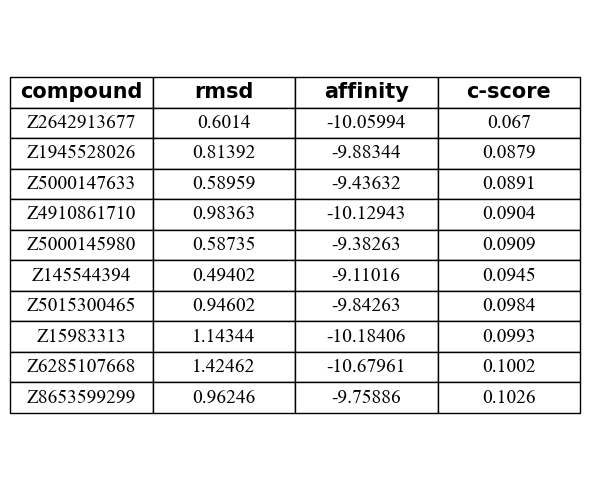

In [62]:
import matplotlib.pyplot as plt

top20_table = best_df.nsmallest(10, 'combined_score')
data = top20_table.rename(columns={'filename': 'compound', 'combined_score': 'c-score'})[['compound', 'rmsd', 'affinity', 'c-score']]
data['c-score'] = data['c-score'].round(4)

fig, ax = plt.subplots(figsize=(6, 5))
ax.axis('off')
table = ax.table(cellText=data.values,
                colLabels=data.columns,
                cellLoc='center',
                loc='center')
table.auto_set_font_size(False)
table.set_fontsize(14)  # Set font size to 10
table.scale(1, 1.5)

# Set font for all cells
for i in range(len(data)):
    for j in range(len(data.columns)):
        table[i + 1, j].set_text_props(fontname='Times New Roman')  # data rows

# Bold the first row (row 1, since row 0 is the header)
for j in range(len(data.columns)):
    table[0, j].set_text_props(weight='bold', fontsize=15)
    
plt.tight_layout()
plt.savefig(f"../Results/images/Top10 compounds from ENAMINE.png", dpi=300)
plt.show()